In [1]:
%matplotlib inline
from pylab import *
from numpy import *
import neuron
import pyNN
from pyNN import neuron
from pyNN.standardmodels import electrodes, build_translations, StandardCurrentSource
from pyNN.parameters import ParameterSpace, Sequence
from pyNN.neuron import simulator
from pyNN.utility import get_simulator, normalized_filename
from pyNN.utility.plotting import Figure, Panel
from neuron import h
from quantities import mV,Hz, s ,ms
import elephant.kernels as kernels

In [2]:
amps = linspace(-5, 5, 20)
cell = neuron.Population(20, neuron.IF_curr_exp(v_thresh = -50.0, tau_refrac = 5.0, tau_m = 10.0))
for cell_id in arange(0,19):
    pulse = neuron.ACSource(start = 20.0, stop = 80.0, amplitude = amps[cell_id], offset = 0.1, frequency = 10, phase = 180.0)
    cell[cell_id].inject(pulse)

In [3]:
cell.record('v')

In [4]:
neuron.run(100.0)

100.00000000001417

In [5]:
vm = cell.get_data().segments[0].filter(name = "v")[0]

In [43]:
vm
savetxt('cellrun.sav', vm)
print (vm)

[[-65.         -65.         -65.         ... -65.         -65.
  -65.        ]
 [-65.         -65.         -65.         ... -65.         -65.
  -65.        ]
 [-65.         -65.         -65.         ... -65.         -65.
  -65.        ]
 ...
 [-66.21770488 -65.67494721 -65.68835934 ... -64.5778564  -64.53966021
  -65.        ]
 [-66.21466821 -65.67326405 -65.68664273 ... -64.57890913 -64.54080819
  -65.        ]
 [-66.21163911 -65.67158509 -65.68493041 ... -64.57995923 -64.5419533
  -65.        ]] mV


In [7]:
neuron.end()

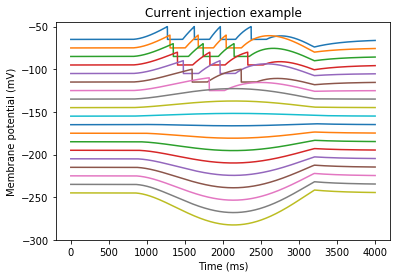

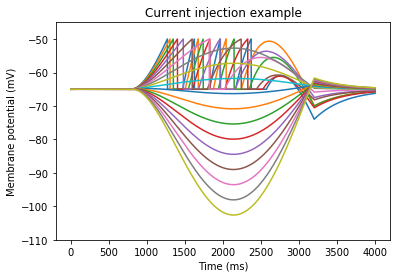

In [110]:
plt.figure()
for cell_id in arange(0,19):
    plt.plot(vm[:,cell_id]-10*mV*cell_id)
plt.xlabel("Time (ms)")
plt.ylabel("Membrane potential (mV)")
plt.ylim(-300, -45)
plt.title("Current injection example");
plt.figure()
for cell_id in arange(0,19):
    plt.plot(vm[:, cell_id])
plt.xlabel("Time (ms)")
plt.ylabel("Membrane potential (mV)")
plt.ylim(-110, -45)
plt.title("Current injection example");

In [9]:
vm[:,0]

AnalogSignal with 1 channels of length 4001; units mV; datatype float64 
name: 'v'
annotations: {'source_ids': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19]), 'source_population': 'population0'}
sampling rate: 40.0
time: 0.0 to 100.025

In [10]:
import elephant as ep

In [11]:
from elephant.spike_train_generation import threshold_detection

In [115]:
trains = {}
for cell_id in arange(0,19):
    trains[cell_id] = threshold_detection(vm[:,cell_id], threshold=-50.01*mV, sign='above')

In [116]:
for train in trains.values():
    if len(train) == 0:
        del train
    print(len(train))
    print(train)

4
[31.725 40.575 49.125 59.25 ] ms
3
[32.575 41.85  51.025] ms
3
[33.65  43.475 53.625] ms
3
[35.025 45.675 58.1  ] ms
2
[36.925 49.   ] ms
2
[39.825 55.95 ] ms
1
[45.45] ms


NameError: name 'train' is not defined

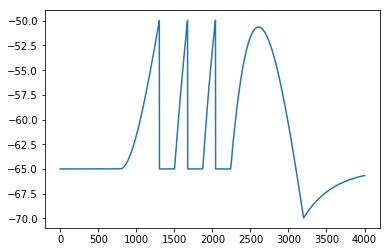

In [117]:
plt.plot(vm[:,1])

In [118]:
from elephant.spike_train_dissimilarity import victor_purpura_dist

[[0.    1.161 1.373 1.316 2.151 2.162 3.147 4.    4.    4.    4.    4.
  4.    4.    4.    4.    4.    4.    4.   ]
 [1.161 0.    0.212 0.534 1.255 1.278 2.144 3.    3.    3.    3.    3.
  3.    3.    3.    3.    3.    3.    3.   ]
 [1.373 0.212 0.    0.322 1.316 1.239 2.079 3.    3.    3.    3.    3.
  3.    3.    3.    3.    3.    3.    3.   ]
 [1.316 0.534 0.322 0.    1.209 1.278 2.009 3.    3.    3.    3.    3.
  3.    3.    3.    3.    3.    3.    3.   ]
 [2.151 1.255 1.316 1.209 0.    0.394 1.142 2.    2.    2.    2.    2.
  2.    2.    2.    2.    2.    2.    2.   ]
 [2.162 1.278 1.239 1.278 0.394 0.    1.225 2.    2.    2.    2.    2.
  2.    2.    2.    2.    2.    2.    2.   ]
 [3.147 2.144 2.079 2.009 1.142 1.225 0.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.   ]
 [4.    3.    3.    3.    2.    2.    1.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.   ]
 [4.    3.    3.    3.    2.    2.    1.    0.    0.    0.    0.    0.
 

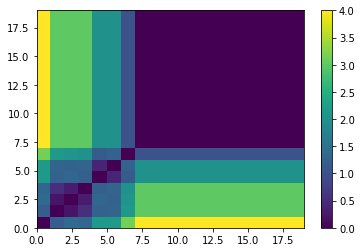

In [119]:
distance_matrix1 = victor_purpura_dist(trains.values(), q=array(40.0) * Hz)
plt.pcolor(distance_matrix1)
plt.colorbar()
print(distance_matrix1)

In [18]:
trains[0][0]

array(31.725) * ms

In [19]:
trains[8].dimensionality.simplified

Dimensionality({second: 1})

In [20]:
import neo
import quantities as pq
for cell_id in arange(0,19):
    print(pq.Quantity(50, "s").dimensionality.simplified,trains[cell_id].dimensionality.simplified,isinstance(trains[4], (pq.quantity.Quantity, neo.core.SpikeTrain)))

s s True
s s True
s s True
s s True
s s True
s s True
s s True
s s True
s s True
s s True
s s True
s s True
s s True
s s True
s s True
s s True
s s True
s s True
s s True


In [21]:
isinstance(trains[16], (pq.quantity.Quantity, neo.core.SpikeTrain))

True

In [22]:
import neo

In [23]:
type(trains[10])

neo.core.spiketrain.SpikeTrain

In [24]:
cell = neuron.Population(10, neuron.IF_curr_exp(v_thresh = -50.0, tau_refrac = 5.0, tau_m = 10.0))

In [25]:
from elephant.spike_train_dissimilarity import van_rossum_dist

[[0.         1.00000002 1.00000004 1.00000003 1.99976255 1.99980054
  2.99963306 3.99954443 3.99954443 3.99954443 3.99954443 3.99954443
  3.99954443 3.99954443 3.99954443 3.99954443 3.99954443 3.99954443
  3.99954443]
 [1.00000002 0.         0.01455983 0.0231069  1.00000002 1.00019694
  1.99985152 2.99975402 2.99975402 2.99975402 2.99975402 2.99975402
  2.99975402 2.99975402 2.99975402 2.99975402 2.99975402 2.99975402
  2.99975402]
 [1.00000004 0.01455983 0.         0.01794364 1.00000002 1.00009299
  1.99982003 2.99973369 2.99973369 2.99973369 2.99973369 2.99973369
  2.99973369 2.99973369 2.99973369 2.99973369 2.99973369 2.99973369
  2.99973369]
 [1.00000003 0.0231069  0.01794364 0.         1.00000003 1.00000002
  1.99977154 2.99969237 2.99969237 2.99969237 2.99969237 2.99969237
  2.99969237 2.99969237 2.99969237 2.99969237 2.99969237 2.99969237
  2.99969237]
 [1.99976255 1.00000002 1.00000002 1.00000003 0.         0.01984846
  1.00000001 1.99987926 1.99987926 1.99987926 1.99987926 1.9

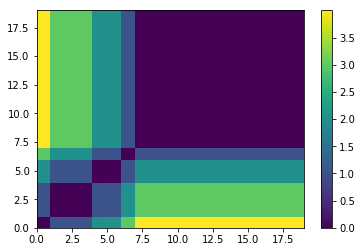

In [26]:
distance_matrix2 = van_rossum_dist(trains.values(), tau=array(50.0) * pq.s, sort = True)
plt.pcolor(distance_matrix2)
plt.colorbar()
print(distance_matrix2)

In [27]:
from elephant.statistics import cost_function, isi, cv
from elephant.spike_train_generation import homogeneous_poisson_process

In [40]:
corrcoef(distance_matrix1)
savetxt('pupuracorrcoef.sav', corrcoef(distance_matrix1))
savetxt('pupuracorrcoef.txt', corrcoef(distance_matrix1))

In [39]:
corrcoef(distance_matrix2)
savetxt('van_rossum.sav', corrcoef(distance_matrix2))
savetxt('van_rossum.txt', corrcoef(distance_matrix2))

In [126]:
from elephant.statistics import complexity_pdf
from elephant.statistics import cost_function

In [127]:
cost_1 = cost_function()

AttributeError: 'int' object has no attribute 'units'